In [98]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib
import json

sns.set_style('darkgrid')

# Data validation
The dataset has 8 columns and 947 rows. After validation we see that the category columns has 11 groupings instead of 10, we grouped the chicken and chicken breast groups together. The servings column isn't numerical, but we won't change its type yet, as it may contain useful information. The rest of the columns are as described in the data dictionary, although calories, carbohydrate, sugar, and protein have missing values. Based on the data dictionary the missing values in the high traffic represent that the traffic is not high, we will encode this column properly.

- Recipe: Numerical, same as dictionary
- Calories: Numerical, same as dictionary. Contains missing values
- Carbohydrate: Numerical, same as dictionary. Contains missing values
- Sugar: Numerical, same as dictionary. Contains missing values
- Protein: Numerical, same as dictionary. Contains missing values
- Category: Character, contains 11 categories instead of 10.
- Servings: Character, isn't numerical. 6 categories
- High traffic: Character. Missing values represent not high traffic. 2 categories, high and nan

In [99]:
df = pd.read_csv('recipe_site_traffic_2212.csv')

In [100]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [101]:
df.info()
# servings data type appears as 'object'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [102]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [103]:
# validate 10 possible categories for 'category'
print('Number of categories: ', df['category'].nunique())
print('Different categories: ', df['category'].unique())
# we have 11 categories, chicken and chicken breasts appear as different categories

Number of categories:  11
Different categories:  ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


In [104]:
# we will change chicken breast to chicken to have 10 categories and better represent the data
df.loc[df['category'] == 'Chicken Breast', 'category'] = 'Chicken'
df['category'] = df['category'].astype('category')

In [105]:
# validate servings
print('Number of categories: ', df['servings'].nunique())
print('Different categories: ', df['servings'].unique())
# Servings doesn´t seem to be numerical, and has snacks categories

Number of categories:  6
Different categories:  ['6' '4' '1' '2' '4 as a snack' '6 as a snack']


In [106]:
# validate high_traffic
print('Number of categories: ', df['high_traffic'].nunique())
print('Different categories: ', df['high_traffic'].unique())

Number of categories:  1
Different categories:  ['High' nan]


# Exploratory analysis
After analysing the target and features of the recipes, and the relationships between target and features I decided to apply the following changes:
- Servings: Drop the snacks categories and change its type to numerical
- High traffic: Encode the target so its 1 when the recipe has high traffic and 0 when it doesn´t
- Missing values: When a row has a missing value, all the float features have a missing value on that row. We will need to fill them

## Missing values
Using the missing values heatmap and matrix we conclude that when a recipe has missing values the calories, carbohydrates, sugar and protein values are missing in the row

<Axes: >

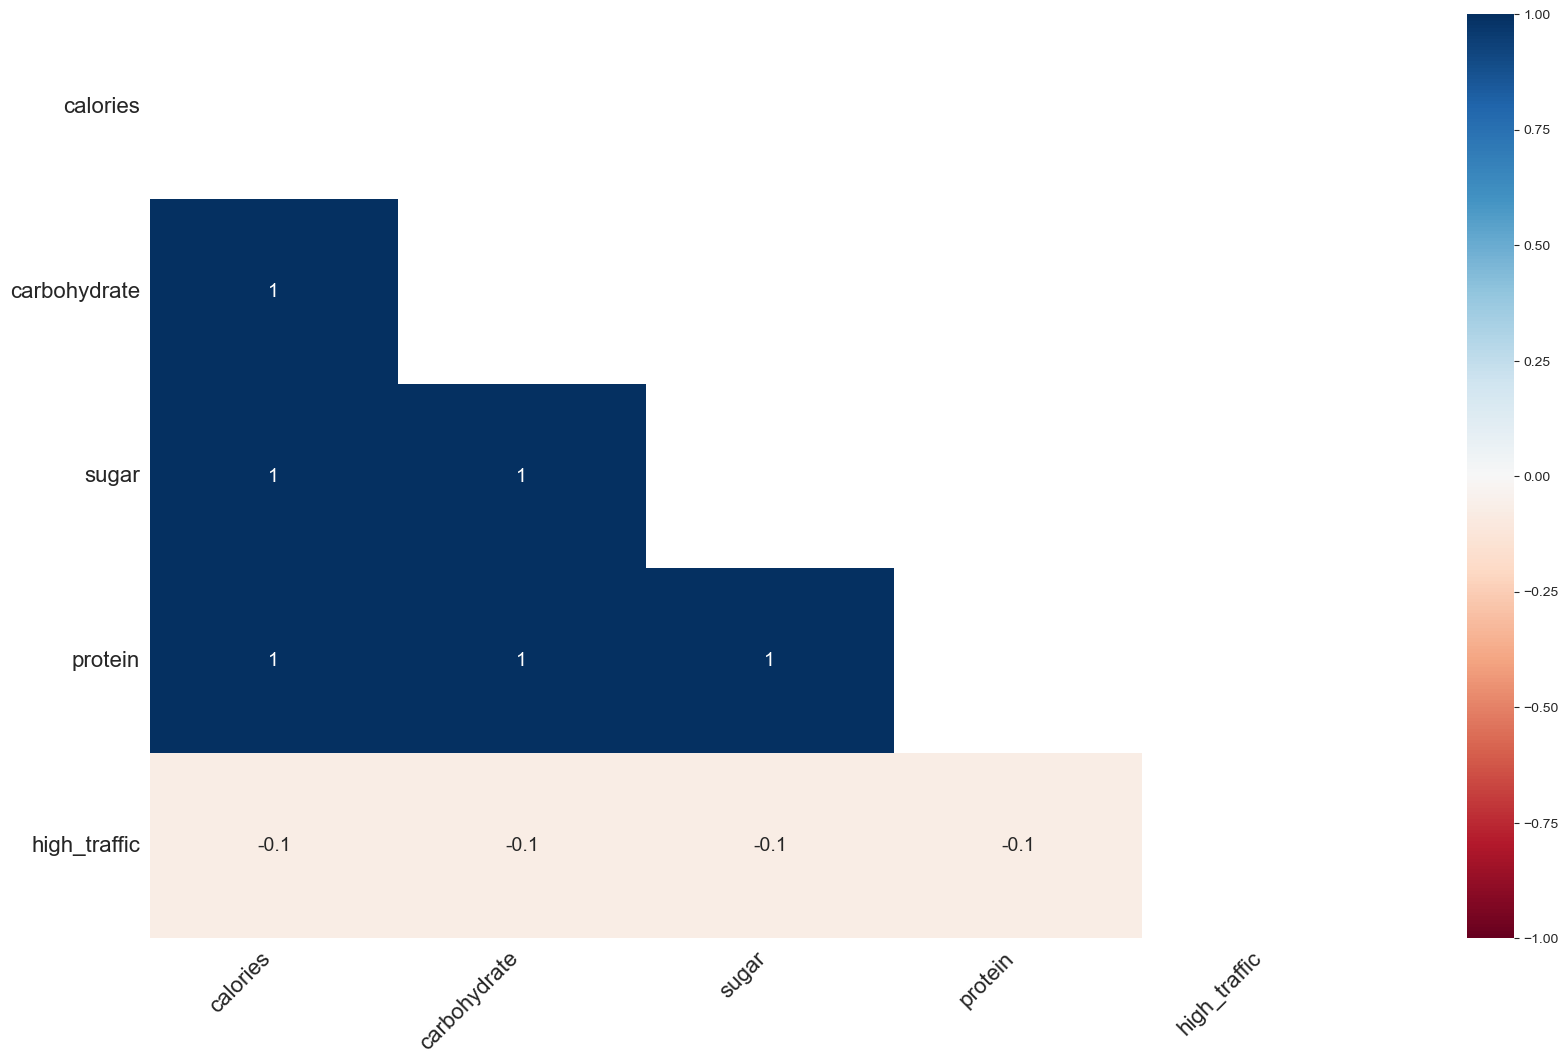

In [107]:
msno.heatmap(df)

<Axes: >

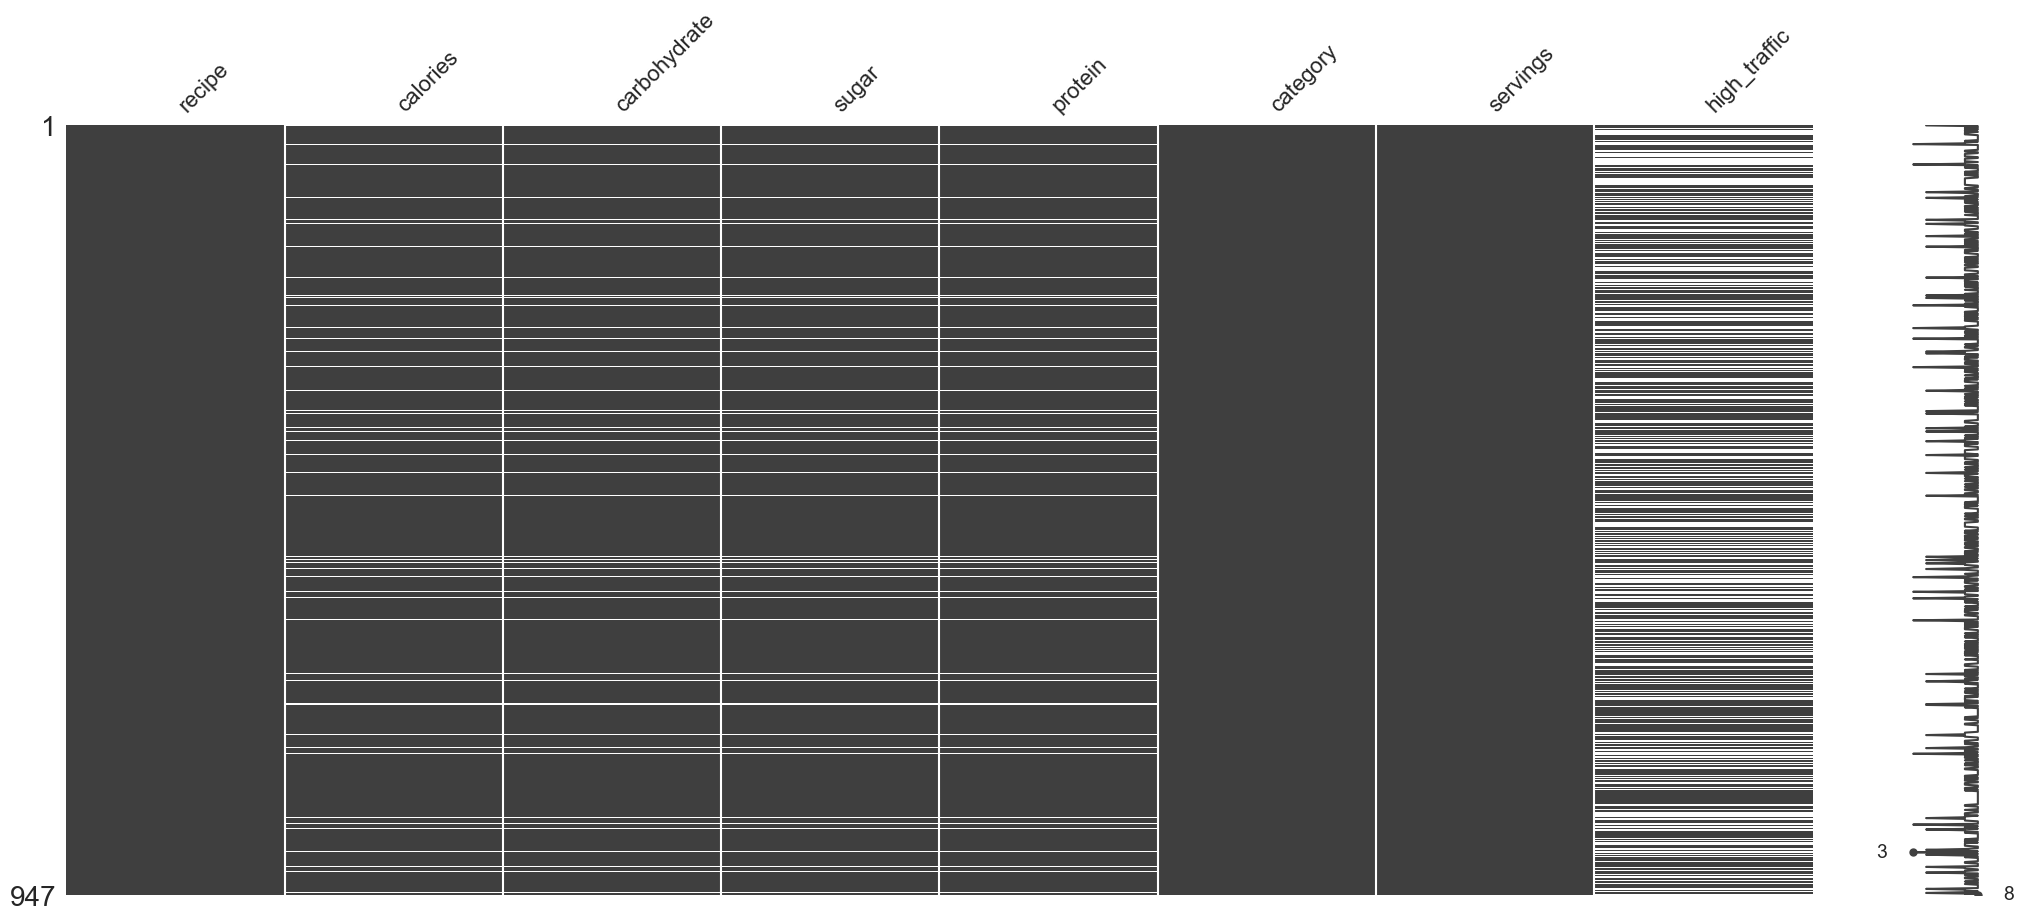

In [108]:
msno.matrix(df)

## Percentage of missing values
About 5% of values for calories, carbohydrates, sugar and protein are missing

In [109]:
print(df.isna().sum()/df.shape[0]*100)

recipe           0.000000
calories         5.491024
carbohydrate     5.491024
sugar            5.491024
protein          5.491024
category         0.000000
servings         0.000000
high_traffic    39.387540
dtype: float64


## Missing values by category
The category with most missing values is pork

In [110]:
#print(df.drop(['category', 'recipe', 'high_traffic'], 1).isna().groupby(df.category, sort=False).sum())

## Target variable - High traffic
Since we are trying to predict witch recipes will be popular, the high traffic variable will be our target. There doesn´t seem to be a high class imbalance in the targe variable, so we will just need to encode it for modelling

<Axes: xlabel='traffic', ylabel='count'>

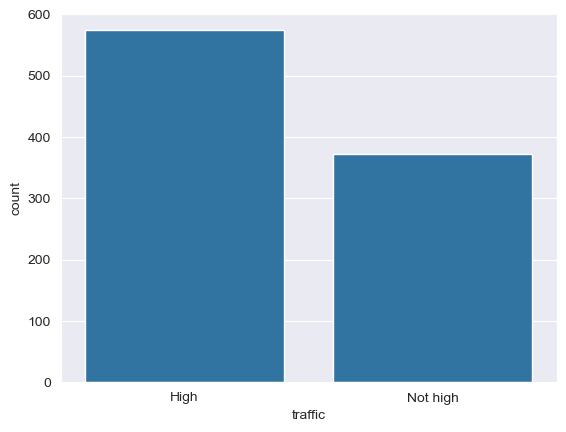

In [111]:
df['traffic'] = df['high_traffic'].apply(lambda x: 'High' if x=='High' else 'Not high')
sns.countplot(x=df['traffic'])

## Numerical features
From the correlation heatmap we can conclude that the is no significant linear correlation betweem the numerical features

In [112]:
#sns.heatmap(df.drop('recipe', 1).corr(),annot=True).set(title='Correlation Heatmap')

## Visualizing non-linear relationships
Some relationships seem to exist, especially between calories and sugar/carbohydrates, and a negative relationship in extreme values of sugar and protein. however, due to the wide spread and the presence of outliers, these relationships don´t seem strong

In [113]:
#sns.pairplot(df.drop('recipe', 1), hue='servings', height=2)

## Distribution of numerical features
The four numerical features have a heavy right skew. We also see the presence of multiple outliers.

[Text(0.5, 1.0, 'Distribution of protein')]

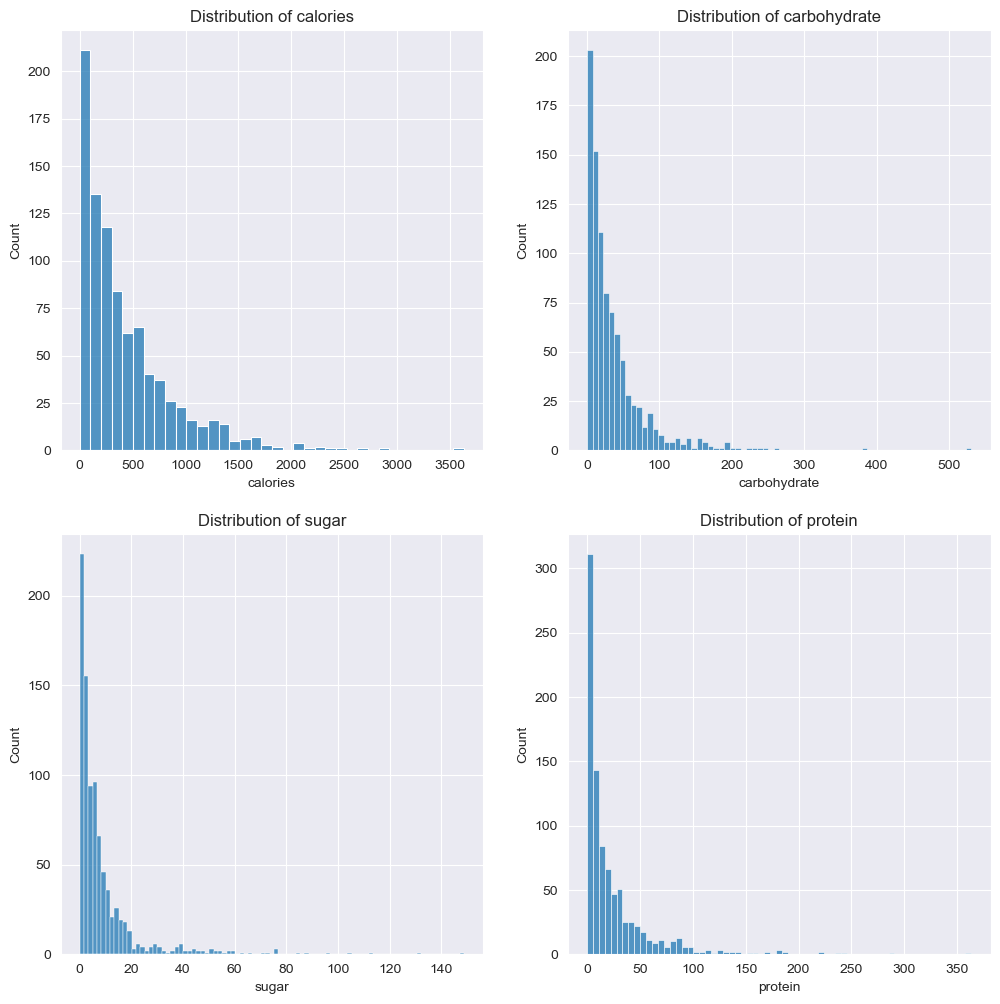

In [114]:
fig, axes = plt.subplots(2,2,figsize=(12,12))

sns.histplot(data=df, x='calories', ax=axes[0,0]).set(title='Distribution of calories')
sns.histplot(data=df, x='carbohydrate', ax=axes[0,1]).set(title='Distribution of carbohydrate')
sns.histplot(data=df, x='sugar', ax=axes[1,0]).set(title='Distribution of sugar')
sns.histplot(data=df, x='protein', ax=axes[1,1]).set(title='Distribution of protein')

[Text(0.5, 1.0, 'Boxplot of protein')]

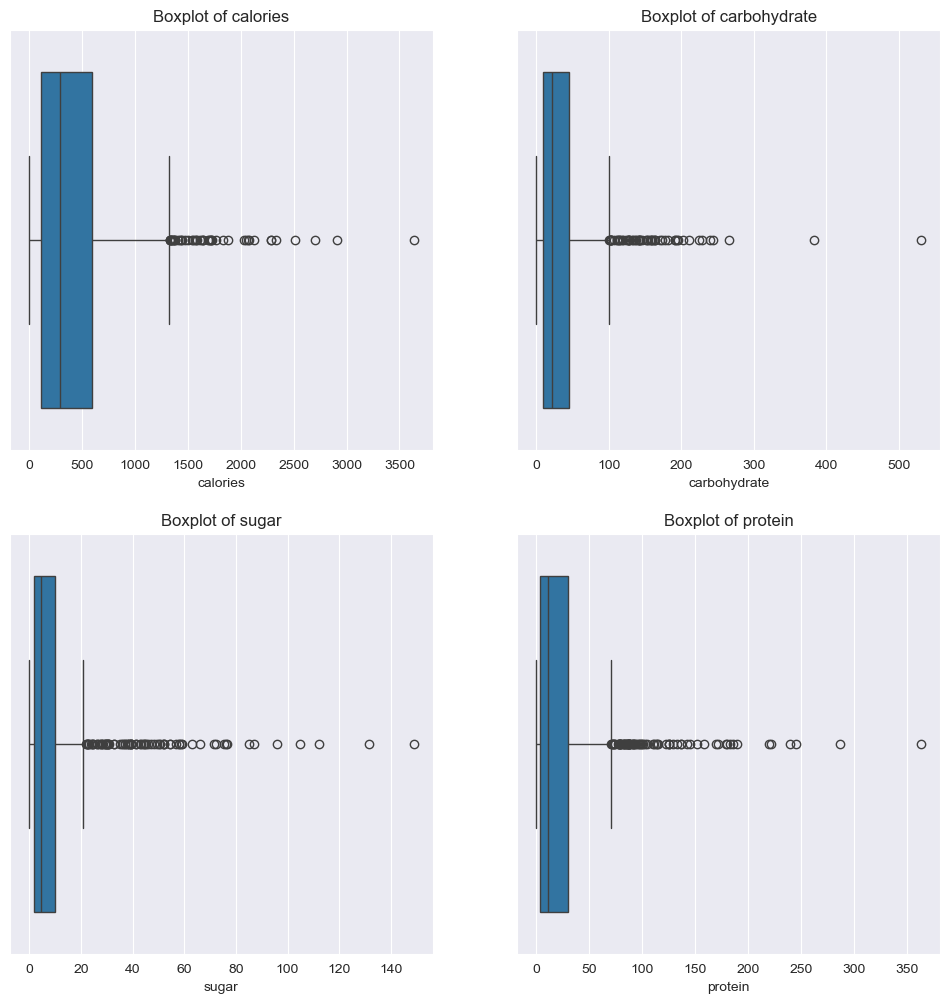

In [115]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.boxplot(data=df, x='calories', ax=axes[0, 0]).set(title='Boxplot of calories')
sns.boxplot(data=df, x='carbohydrate', ax=axes[0, 1]).set(title='Boxplot of carbohydrate')
sns.boxplot(data=df, x='sugar', ax=axes[1, 0]).set(title='Boxplot of sugar')
sns.boxplot(data=df, x='protein', ax=axes[1, 1]).set(title='Boxplot of protein')

## Numerical features against target variable
High traffic recipes have on average a higher content of calories, carbohydrates and protein but a lower content of sugar compared to not high traffic recipes

[Text(0.5, 1.0, 'Average protein by traffic')]

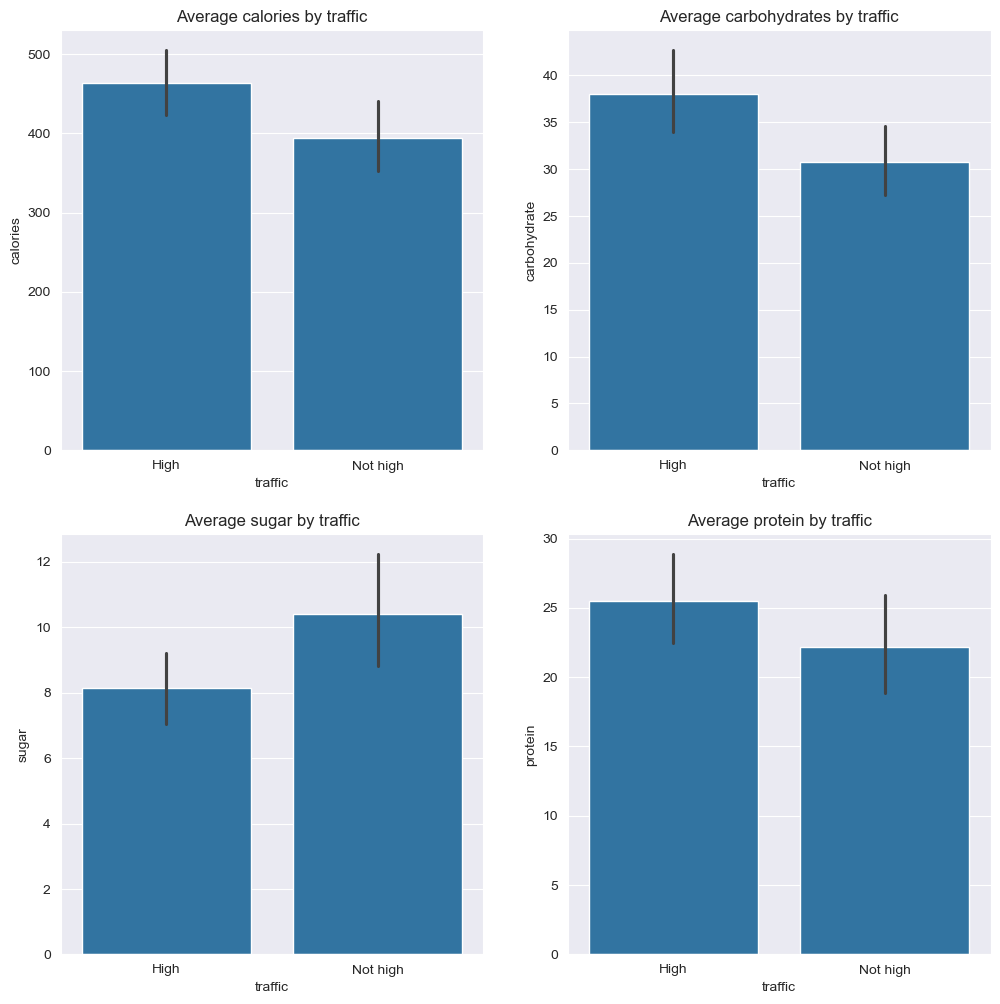

In [116]:
fig, axes = plt.subplots(2,2,figsize=(12,12))
sns.barplot(data=df, x='traffic', y='calories', ax=axes[0,0]).set(title='Average calories by traffic')
sns.barplot(data=df, x='traffic', y='carbohydrate', ax=axes[0,1]).set(title='Average carbohydrates by traffic')
sns.barplot(data=df, x='traffic', y='sugar', ax=axes[1,0]).set(title='Average sugar by traffic')
sns.barplot(data=df, x='traffic', y='protein', ax=axes[1,1]).set(title='Average protein by traffic')

## Categorical features
We see that for categories the classes are pretty balanced, but the snacks categories in servings have close to no observations. we will just drop the snacks rows and convert servings to numerical

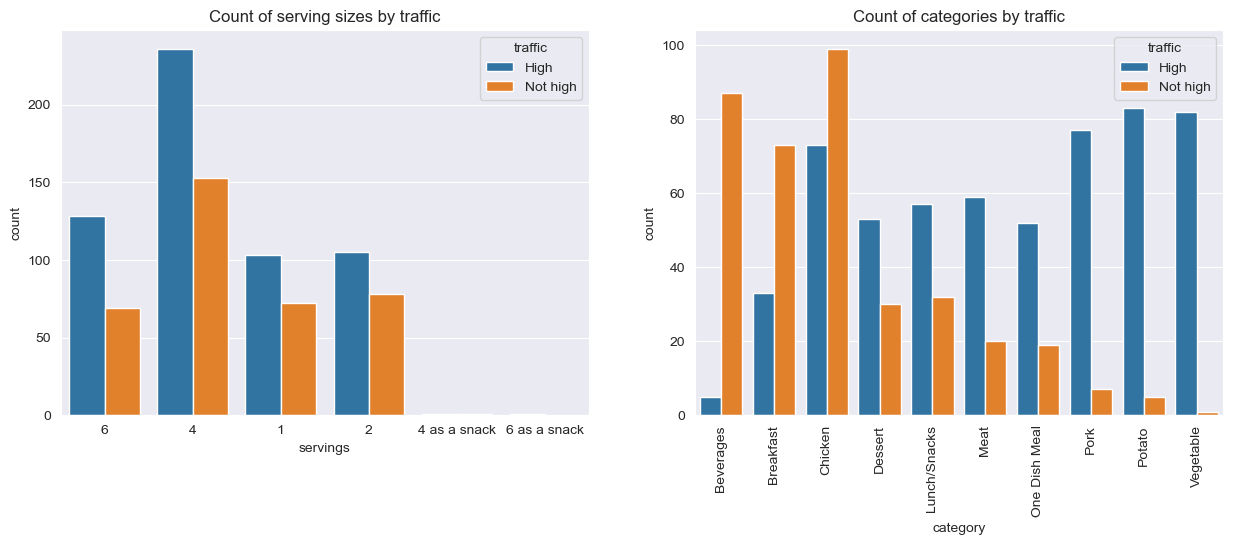

In [117]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.countplot(x=df['servings'], hue=df['traffic'], ax=axes[0]).set(title='Count of serving sizes by traffic')
sns.countplot(x=df['category'], hue=df['traffic'], ax=axes[1]).set(title='Count of categories by traffic')

axes[1].tick_params(axis='x', labelrotation=90)

## Snacks categories
We see that we only have 2 observations for  '4 as a snack' category and 1 for '6 as a snack'. It will be difficult to get good predictions for this servings. If they had a similar amount of calories as certain serving size maybe we could have group the with it, but they are too different from the others servings. Given that we only have 3 observations and they are extreme outliers I think the correct choice is to drop them and reduce variance

[Text(0.5, 1.0, 'Count of snack servings')]

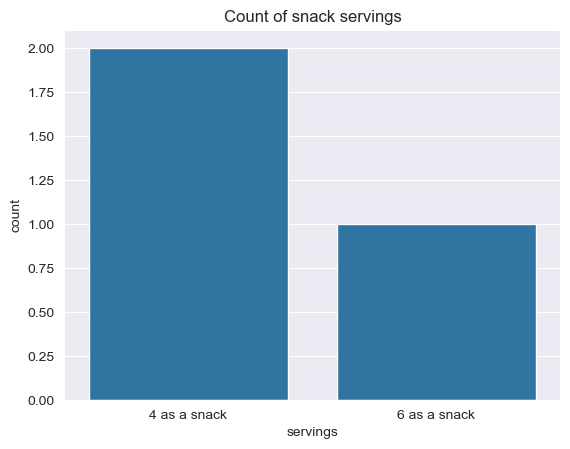

In [118]:
snacks = df.loc[(df['servings'] == '4 as a snack') | (df['servings'] == '6 as a snack')]
sns.countplot(x=snacks['servings']).set(title='Count of snack servings')

[Text(0.5, 1.0, 'Calories by serving size')]

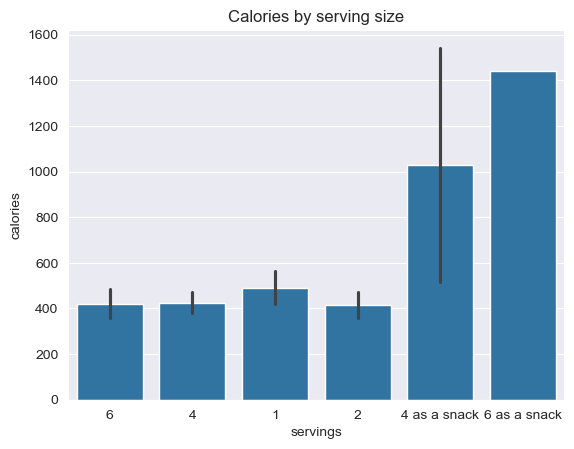

In [119]:
sns.barplot(x=df['servings'], y=df['calories']).set(title='Calories by serving size')

## Comparing the high traffic ratios
We also see that pork, potato and vegetables recipes have the highest high to not high traffic ratio, while beverages and breakfast have the lowest

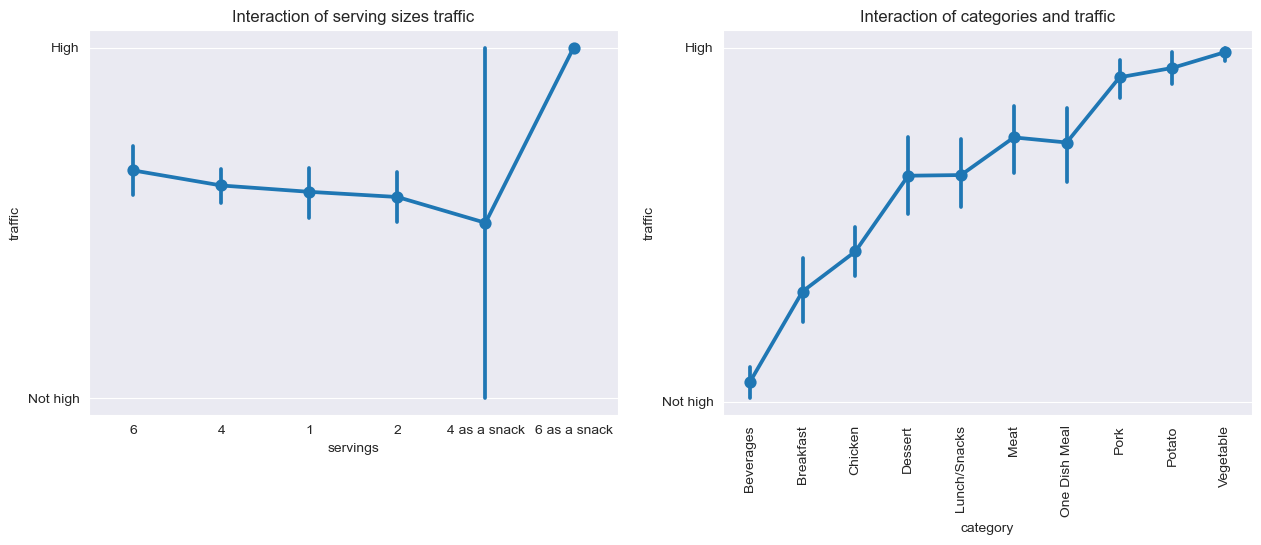

In [120]:

fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.pointplot(x=df['servings'], y=df['traffic'], ax=axes[0]).set(title='Interaction of serving sizes traffic')
sns.pointplot(x=df['category'], y=df['traffic'], ax=axes[1]).set(title='Interaction of categories and traffic')

axes[1].tick_params(axis='x', labelrotation=90)

# Model fitting and evaluation
Predicting if a recipe will have high traffic or not is a binary classification problem. Since we only have 2 classes in the target variable and we don´t seem to have strong correlation between features I´m choosing the Logistic Regression model for its simplicity and interpretability, it will work well as a baseline. As the comparison model I´m choosing the Random Forest Classifier for its robustness to outliers and ability to learn non-linear relationships.

For evaluation of the models I will be using *accuracy* and *precision*. Accuracy will tell us how often the model correctly predicts the outcome. As the product manager has asked us to correctly predict high traffic recipes 80% of the time, this seems like a problem to use precision. As we don´t want to show a recipe that will generate low traffic, we want to minimize false positives. In this case we would want a precision of at least 0.80. In addition to this metrics we will use the confusion matrix to more visually represent the quality of the model.

## Preparing data for modelling
- Normalize numerical features
- Encode categorical features
- Encode target variable
- Drop low occurrence categories in 'servings'
- Drop recipe variable
- Split data in train and test
- Fill missing values

## Droping variables and filling missing values

In [121]:
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)
df.drop(['traffic','recipe'], axis=1, inplace=True)

Fill the missing values in the numerical features using the median value of each category

In [122]:
df[['sugar', 'carbohydrate', 'protein', 'calories']] = (
    df.groupby('category')[['sugar', 'carbohydrate', 'protein', 'calories']]
    .transform(lambda x: x.fillna(x.median()))
)

C:\Users\Windows\AppData\Local\Temp\ipykernel_9412\2877890963.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('category')[['sugar', 'carbohydrate', 'protein', 'calories']]


In [123]:
df.isna().sum()

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

Drop low occurrence servings categories

In [124]:
df = df[~df['servings'].str.contains('as a snack')]
df['servings'] = df['servings'].astype(int)

## Transforming numerical features

In [125]:
transfomer = PowerTransformer()
numerical_cols = ['sugar', 'carbohydrate','calories','protein','servings']
df[numerical_cols] = transfomer.fit_transform(df[numerical_cols])

## Encode categorical features
As we don´t have an excessive amount of categories in the category feature and the classes are balanced we will use dummy variables

In [126]:
df = pd.get_dummies(df, columns=['category'], prefix='category')

## Selecting target and features, splitting the data for training and testing

In [127]:
X = df.drop('high_traffic', axis=1)
y = df['high_traffic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=23)

## Logistic regression model

In [128]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

## Logistic regression metrics

In [129]:
y_pred = lr.predict(X_test)

print('Logistic Regression accuracy: ',accuracy_score(y_test,y_pred))
print('Logistic Regression precision score: ',precision_score(y_test,y_pred))

lr_precision = precision_score(y_test,y_pred)
lr_accuracy = accuracy_score(y_test,y_pred)

Logistic Regression accuracy:  0.7457627118644068
Logistic Regression precision score:  0.8217054263565892


## Logistic regression confusion matrix

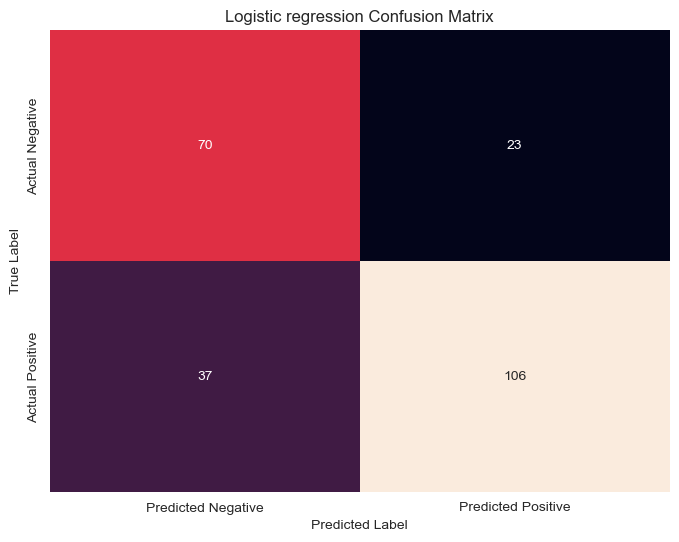

In [130]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic regression Confusion Matrix")
plt.show()

As we saw in the exploratory analysis, the pork, potato and vegetable categories seem to be amazing predictors for high traffic

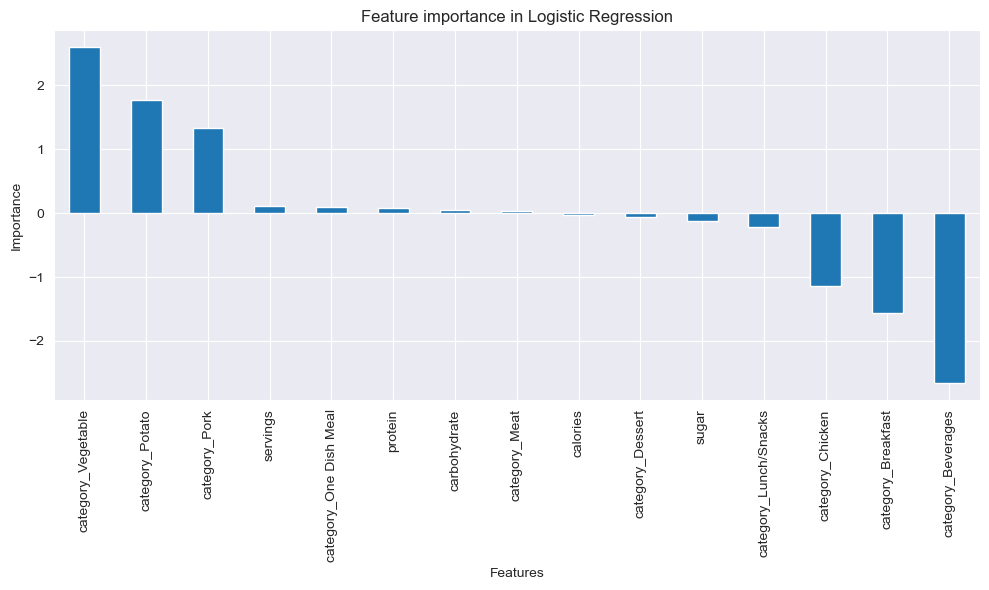

In [131]:
feature_importance = pd.Series(lr.coef_[0], index=X_train.columns).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Random Forest Classifier

Testing for best depth

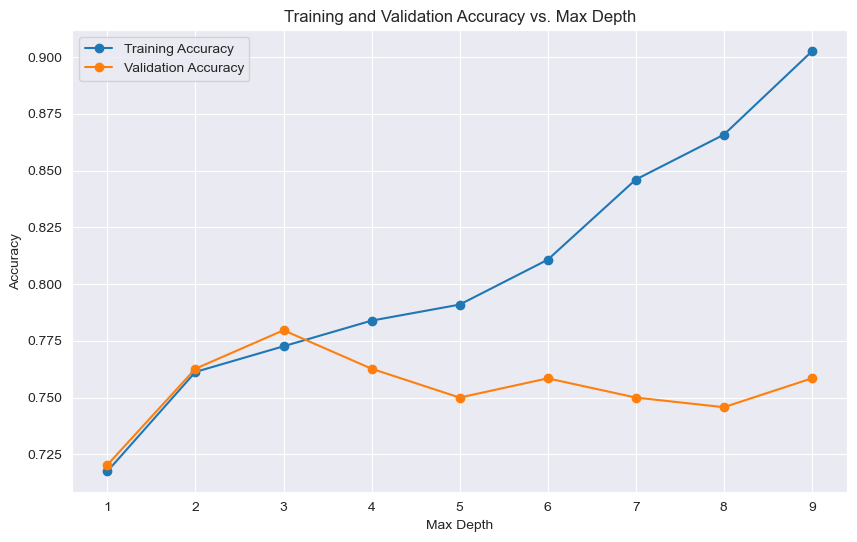

In [132]:
depth_range = range(1, 10)

training_accuracies = []
validation_accuracies = []

for depth in depth_range:
    rf = RandomForestClassifier(max_depth=depth, random_state=23, class_weight='balanced')
    rf.fit(X_train, y_train)
    
    y_train_pred = rf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    training_accuracies.append(train_accuracy)

    y_test_pred = rf.predict(X_test)
    val_accuracy = accuracy_score(y_test, y_test_pred)
    validation_accuracies.append(val_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(depth_range, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(depth_range, validation_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Max Depth')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
rf = RandomForestClassifier(max_depth=3, random_state=23, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=23)

## Random Forest metrics

In [134]:
y_pred = rf.predict(X_test)

print('Random Forest accuracy: ',accuracy_score(y_test,y_pred))
print('Random Forest precision score: ',precision_score(y_test,y_pred))

rf_precision = precision_score(y_test,y_pred)
rf_accuracy = accuracy_score(y_test,y_pred)

Random Forest accuracy:  0.7796610169491526
Random Forest precision score:  0.8226950354609929


## Random Forest confusion matrix

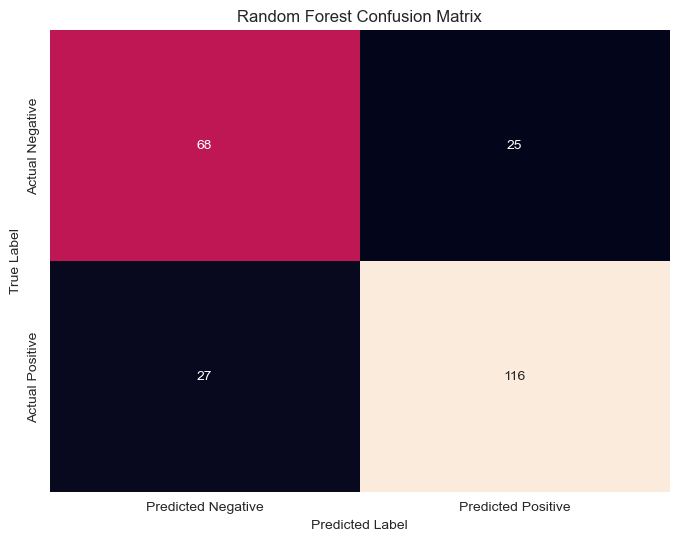

In [135]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()

## Random Forest feature importance

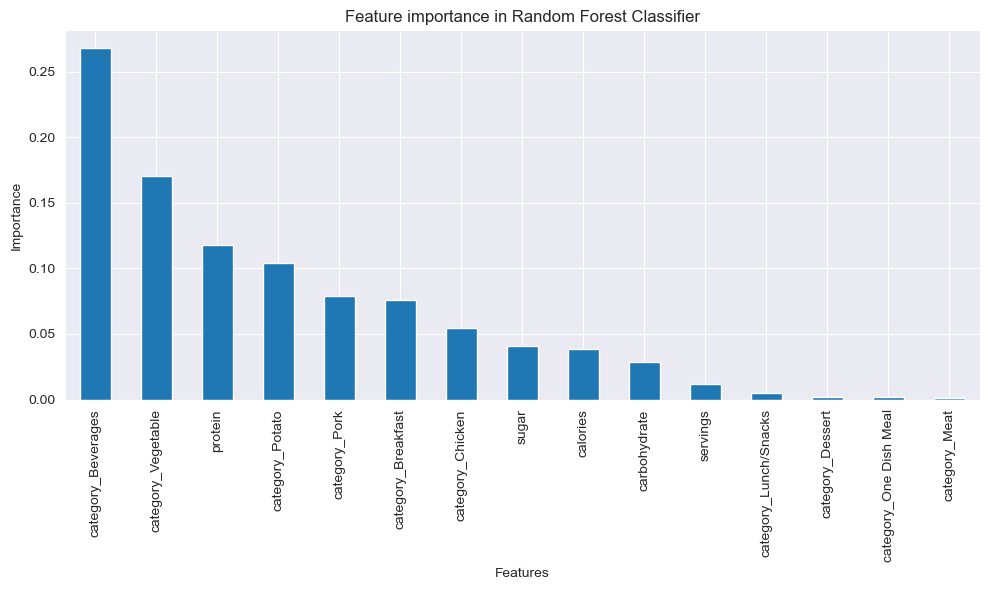

In [136]:
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature importance in Random Forest Classifier')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [137]:
rf = RandomForestClassifier(max_depth=3, random_state=23, class_weight='balanced')
rf.fit(X, y)

joblib.dump(rf, 'recipe_traffic_model.joblib')

transfomer = PowerTransformer()
numerical_cols = ['sugar', 'carbohydrate','calories','protein','servings']
transfomer.fit(X[numerical_cols])

joblib.dump(transfomer, 'recipe_traffic_transformer.joblib')

features = X.columns.tolist()

with open('features.json', 'w') as f:
    json.dump(features, f)

# Results
The accuracy of the Logistic Regression model is 0.7457, the Random Forest Classifier accuracy is 0.7796. This means that the RF is better for predicting the outcome of the recipes, if they will be high traffic or not. The Logistic Regression has a precision score of 0.8217, while the Random Forest has a precision score of 0.8226. Both models have similar precision, so they will perform nearly equally for making sure that the recipes we predict as high traffic actually are high traffic.

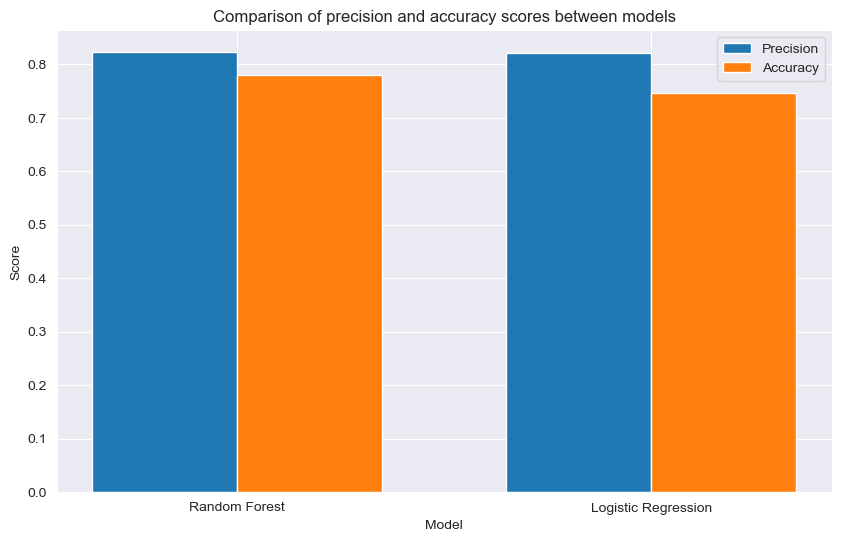

In [138]:
scores = {
    'Random Forest': [rf_precision, rf_accuracy],
    'Logistic Regression': [lr_precision, lr_accuracy]
}
metrics = ['Precision', 'Accuracy']

x = np.arange(len(scores)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [scores[model][0] for model in scores], width, label='Precision')
bars2 = ax.bar(x + width/2, [scores[model][1] for model in scores], width, label='Accuracy')


ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparison of precision and accuracy scores between models')
ax.set_xticks(x)
ax.set_xticklabels(scores.keys())
ax.legend()

plt.show()

# Evaluation by business criteria
The product manager has asked us to correctly predict high traffic recipes 80% of the time, because of this it would be appropriate to use precision score as a kpi. We want to be sure the recipes we recomend are actually going to bring high traffic. Both models fulfill this objective, the RF being at a slight advantage. The RF, also having a higher accuracy, is better abled to predict the outcome of a recipe, being either high or not high traffic.

# Recomendation
I would recomend deploying the Random Forest for everyday use, its higher precision will help us be more confident that the recipes we display on the home page everyday will drive high traffic. Its higher accuracy will also be of use if we don´t have many recipes left as candidates, as the Logistic Regression might predict that a recipe would not generate high traffic when it actually would. I still think the Logistic Regression could be of use to present our findings to stakeholders given that although it has lower accuracy, it can make up for it with its higher interpretability.

The recomendations I have to deploy and improve the Random Forest Classifier regularly are the following:

1. Look into why we have recipes with all the nutrients a calories missing. We don´t have an excessively large dataset so every observation matters, and we could be loosing important information.
2. Tune hyperparameters of the Random Forest.
3. Collect more data on the snacks categories of servings. Right now there is too little data to get conclusions from these categories.
4. Test the model by comparing its predictions to the product manager recipe choices for the home page.